In [9]:
%pylab inline
from astropy.table import Table
import sys
sys.path.insert(0, '../../')
from cosmoml.estimators import RNNClassifier
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table

In [3]:
# Loading dataset
data_table = Table.read('ligthcurve_data.fits.gz')

# Splitting training and testing data
randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)
randomized_inds_train = randomize_inds[0:70000]
randomized_inds_test  = randomize_inds[70000:]

In [10]:
# Define input function for training 
def input_fn_train():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['coadd_label'][inds].astype('float32'), clip(data_table['obs_len'][inds],0,89).astype('int32'),clip(data_table['time_series'][inds].astype('float32'),-10,10) 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,90,12])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.repeat().shuffle(50000).batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

# Define input function for testing on the training set
def input_fn_train_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['coadd_label'][inds].astype('float32'), clip(data_table['obs_len'][inds],0,89).astype('int32'),clip(data_table['time_series'][inds].astype('float32'),-10,10)
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,90,12])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

# Define input function for testing on the testing set
def input_fn_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_test[inds]
            return data_table['coadd_label'][inds].astype('float32'), clip(data_table['obs_len'][inds],0,89).astype('int32'),clip(data_table['time_series'][inds].astype('float32'),-10,10) 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,90,12])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_test))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function )
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

In [11]:
# Create the model
model = RNNClassifier(hidden_units=[128,128], dropout=0.5, model_dir='/data2/rnn/logs/rnn_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data2/rnn/logs/rnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f683d97ab00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
model.train(input_fn_train, steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /data2/rnn/logs/rnn_model/model.ckpt.
INFO:tensorflow:loss = 0.6950476, step = 0
INFO:tensorflow:global_step/sec: 10.5303
INFO:tensorflow:loss = 0.4258965, step = 100 (9.498 sec)
INFO:tensorflow:global_step/sec: 10.7358
INFO:tensorflow:loss = 0.2522667, step = 200 (9.315 sec)
INFO:tensorflow:global_step/sec: 10.7864
INFO:tensorflow:loss = 0.16097799, step = 300 (9.271 sec)
INFO:tensorflow:global_step/sec: 10.7661
INFO:tensorflow:loss = 0.15138446, step = 400 (9.288 sec)
INFO:tensorflow:global_step/sec: 10.8085
INFO:tensorflow:loss = 0.11992348, step = 500 (9.252 sec)
INFO:tensorflow:global_step/sec: 10.7887
INFO:tensorflow:loss = 0.09733226, step = 600 (9.269 sec)
INFO:tensorflow:global_step/sec: 10.7942
INF

In [13]:
# Apply model to testing set
test_prob = [p['prob'] for p in model.predict(input_fn_test)]
table_test = data_table[randomized_inds_test]
table_test['p'] = test_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/rnn/logs/rnn_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:
# Apply model to training set
train_prob = [p['prob'] for p in model.predict(input_fn_train_test)]
table_train = data_table[randomized_inds_train]
table_train['p'] = train_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/rnn/logs/rnn_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


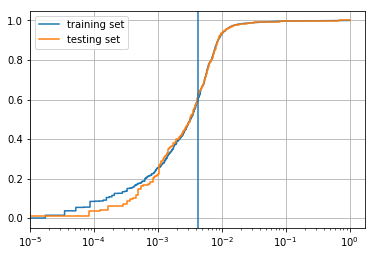

In [15]:
# Compute ROC curves 
from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(table_train['coadd_label'], table_train['p'])
fpr2, tpr2, thr2 = roc_curve(table_test['coadd_label'], table_test['p'])

plot(fpr1, tpr1,label='training set')
plot(fpr2, tpr2,label='testing set')
grid('on')
xscale('log')
legend()
axvline(0.0043)

In [16]:
# Computes colors
table_test['ug'] = table_test['coadd_psfMag_u'] - table_test['coadd_psfMag_g'] 
table_test['gr'] = table_test['coadd_psfMag_g'] - table_test['coadd_psfMag_r'] 
table_test['ri'] = table_test['coadd_psfMag_r'] - table_test['coadd_psfMag_i'] 
table_test['iz'] = table_test['coadd_psfMag_i'] - table_test['coadd_psfMag_z'] 

In [19]:
threshold=0.90
# Splits the testing set
FP = (table_test['p'] > threshold) * (table_test['coadd_label'] == 0)
FN = (table_test['p'] < threshold) * (table_test['coadd_label'] == 1)
P = (table_test['coadd_label'] == 1)
N = (table_test['coadd_label'] == 0)

t_fp = table_test[FP]
t_fn = table_test[FN]
t_p = table_test[P]
t_n = table_test[N]


print(len(table_test[FP]))
print(len(table_test[FN]))

203
604


(0, 1)

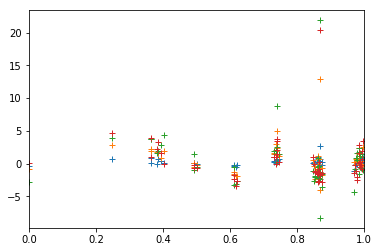

In [20]:
# Plot light curve for a false positive
plot(t_fp['time_series'][0,:,0], t_fp['time_series'][0,:,1],'+')
plot(t_fp['time_series'][0,:,0], t_fp['time_series'][0,:,2],'+')
plot(t_fp['time_series'][0,:,0], t_fp['time_series'][0,:,3],'+')
plot(t_fp['time_series'][0,:,0], t_fp['time_series'][0,:,4],'+')
xlim(0,1)

Text(0.5,0.98,'Variability only false positives')

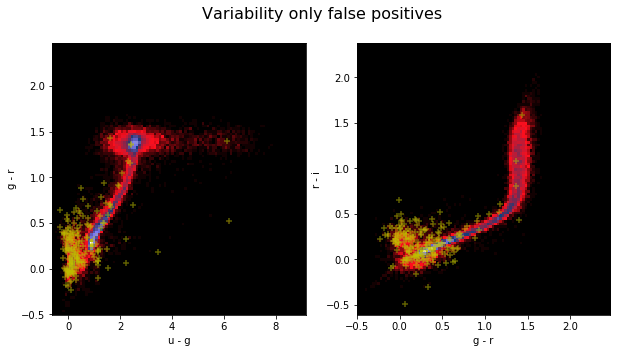

In [21]:
# False positive in color space
figure(figsize=(10,5))
title('False positive in color space')
subplot(121)
hist2d(table_test['ug'], table_test['gr'],100,cmap='gist_stern');
scatter(t_fp['ug'],t_fp['gr'],alpha=0.5,c='y', marker='+')
xlabel('u - g')
ylabel('g - r')

subplot(122)
hist2d(table_test['gr'], table_test['ri'],100,cmap='gist_stern');
scatter(t_fp['gr'],t_fp['ri'],alpha=0.5,c='y', marker='+')
xlabel('g - r')
ylabel('r - i')

suptitle('Variability only false positives', fontsize=16)

Text(0.5,0.98,'Variability only false negatives')

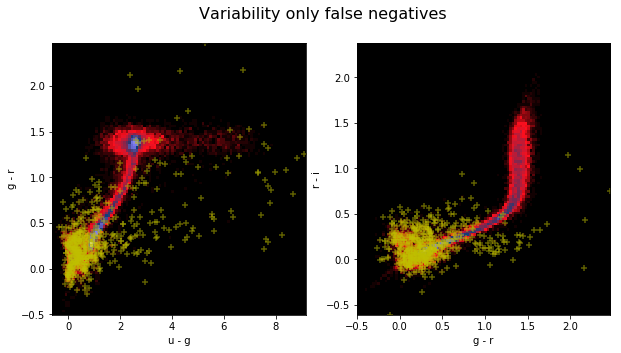

In [22]:
# False positive in color space
figure(figsize=(10,5))
subplot(121)
hist2d(table_test['ug'], table_test['gr'],100,cmap='gist_stern');
scatter(t_fn['ug'],t_fn['gr'],alpha=0.5,c='y', marker='+')
xlabel('u - g')
ylabel('g - r')

subplot(122)
hist2d(table_test['gr'], table_test['ri'],100,cmap='gist_stern');
scatter(t_fn['gr'],t_fn['ri'],alpha=0.5,c='y', marker='+')
xlabel('g - r')
ylabel('r - i')

suptitle('Variability only false negatives', fontsize=16)

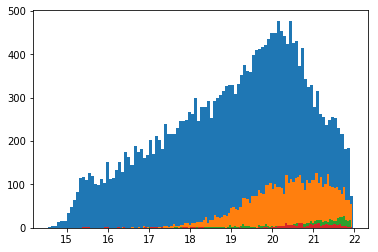

In [23]:
# Looks at the distribution of these in terms of coadded imag
hist(t_n['coadd_psfMag_i'],100);
hist(t_p['coadd_psfMag_i'],100);
hist(t_fn['coadd_psfMag_i'],100);
hist(t_fp['coadd_psfMag_i'],100);